# **MODELO DE HOMEOSTASIS LISOSOMAL**
Armstrong(2003)

---

*Cristian Castillo,2022*

## **1. Descripción**
El siguiente modelo continuo de homeostasis lisosomal se define a través de ecuaciones diferenciales que describen el flujo de iones que permean la capa bilipídica de un lisosoma. En la Figura 1 se muestra un esquema que resume los mecanismos considerados en el modelo.

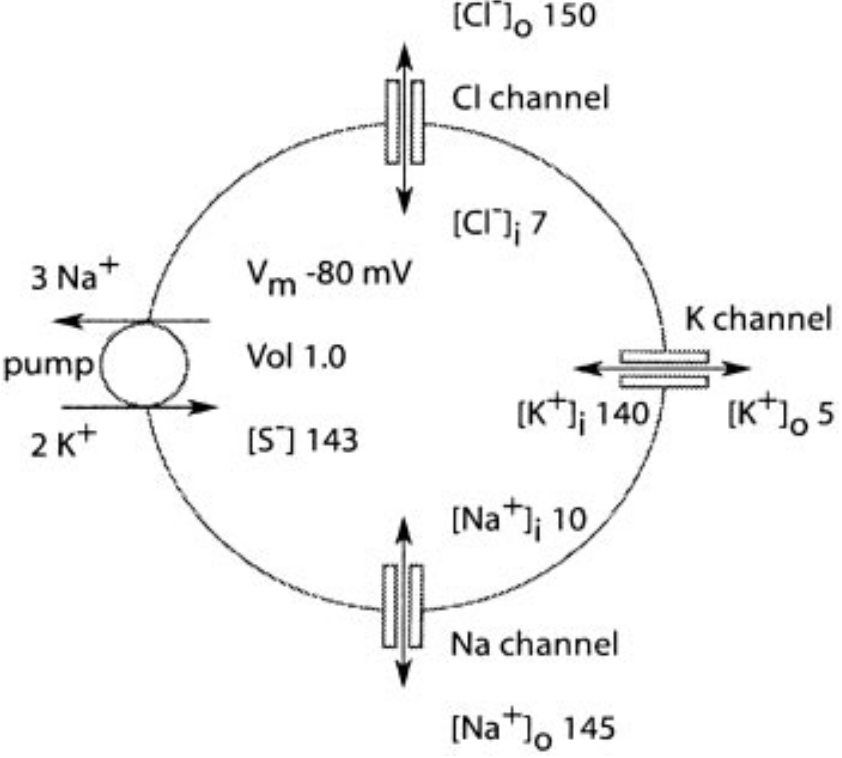

>**Figura 1.** Esquema de componentes incluidos en Armstrong(2003)




## **2. Componentes**

### **2.1. Potencial de membrana**

(Armstrong 2003) calcula el potencial de membrana $V_m$ usando la ecuación de Goldman (eq.1). Ésta depende de las permeabilidades de los canales y sus concentraciones internas y externas ($A$niones y $C$ationes), además de la contribución de las bombas e intercambiadores.


\begin{equation}
{\displaystyle V_m ={\frac {RT}{F}}\ln {\left({\frac {\sum _{i}^{n}P_{C_{i}^{+}}[C_{i}^{+}]_{\mathrm {out} }+\sum _{j}^{m}P_{A_{j}^{-}}[A_{j}^{-}]_{\mathrm {in} } + \frac{I_{pump_{k}}}{F}}{\sum _{i}^{n}P_{C_{i}^{+}}[C_{i}^{+}]_{\mathrm {in} }+\sum _{j}^{m}P_{A_{j}^{-}}[A_{j}^{-}]_{\mathrm {out} }}}\right)}}\;\;\;\;\;\; (1)
\end{equation}


### **2.3. Canales pasivos**
De (Armstrong 2003), los canales de, K+, Na+ y Cl- que permiten el movimiento pasivo de estos iones. La electrodifusión está determinada por la siguiente ecuación de flujo de GHK:

* Para un ión positivo:

\begin{equation}
I_{X^+} = P_{X^+} \; F \; z_{X^+} ([X^+]_i e^{\psi} - [X^+]_o) \;\;\;\;\;\; (2)
\end{equation}

* Para un ión negativo:

\begin{equation}
I_{X^-} = P_{X^-} \; F \;  z_{X^-} ([X^-]_o e^{\psi} - [X^-]_i) \;\;\;\;\;\; (3)
\end{equation}

En donde $\psi$ es:

\begin{equation}
\psi = \frac{z_x V_m F} { R T} \;\;\;\;\;\; (4)
\end{equation}

Tal que:
* $P_x$: Número de poros/cm^2 por la permeabilidad de un poro único
* $\psi$: Razón del potencial a una energía termal aleatoria

El flujo pasivo de los iones restantes se describe de forma similar, de acuerdo a las siguientes ecuaciones:
\begin{equation}
I_K = P_{K^+} \; F \; z_{K^+} ([K^+]_i e^{\psi} - [K^+]_o)  \;\;\;\;\;\; (10)
\end{equation}


\begin{equation}
I_{Cl^-} = P_{Cl^-} \; F \;  z_{Cl^-} ([Cl^-]_o e^{\psi} - [Cl^-]_i) \;\;\;\;\;\; (3)
\end{equation}




## **3. Desarrollo de modelo**
### **3.1. Librerías a usar**

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from matplotlib import cm
from scipy import interpolate
from scipy.integrate import odeint
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from time import time
from scipy import signal
import itertools

In [70]:
# --------------------------------------------
#   PARÁMETROS DEL MODELO  ARMSTRONG         #
# --------------------------------------------
# Concentraciones citosólicas
Na_C = 0.145  # M (145mM) Armstrong(2003)   (0.01M)Astaburuaga(2019)
K_C  = 0.005  # M (5mM)   Armstrong(2003)   (0.145M)Astaburuaga(2019)
Cl_C = 0.150  # M (150mM) Armstrong(2003)   (0.01)Astaburuaga(2019)
S_C  = 0.143
# ---------------------------------#
# Concentraciones luminales
Na_L = 0.010  # M  (10 mM)  Armstrong(2003)  (0.02M) Astaburuaga(2019)  Ishida(0.145)
K_L  = 0.140  # M  (140 mM) Armstrong(2003)  (0.05M) Astaburuaga(2019)  Ishida(0.005)
Cl_L = 0.007  # M  (7  mM)  Armstrong(2003)  (0.001M)Astaburuaga(2019)  Ishida (0.110)
# ---------------------------------#
# Permeabilidades (Relativas)
P_Na = 0.02
P_K  = 1
P_Cl = 2.0   
# ---------------------------------#
# Constantes
NA  = 6.02e+23
F   = 96485
R   = 8.314
T   = 300
RTF = 25.69
# ---------------------------------#
# Geometrías del lisosoma
Vol = 1.646365952e-16 
S = 1.45267584e-08   #(cm^2)
cap = 1.45267584e-14
cap_0 = 1e-6
# -------------------------------#
# Z
z_Cl = -1
z_Na = 1
z_K  = 1
# V_m
psi_out=0
#
Ipump=0

In [92]:
Ipump=0
m3tocm3 = 1e-6
Pump_ratio = 3/2
Na_c = 0.2
ATP = 0.003

# Inicio
top = P_Na*Na_o + P_K*K_o + P_Cl*Cl_i - Ipump/F
under = P_Na*Na_i + P_K*K_i + P_Cl*Cl_o
V_m = (R*T)/F*np.log(top/under)
print(V_m)
# Cálculo de flujos pasivos
FoverRT=F/(R*T)  
I_K  = P_K  * F * z_K  * (K_i  * np.exp(FoverRT*V_m*z_K) - K_o)  * m3tocm3 #[C/(scm2)]
I_Na = P_Na * F * z_Na * (Na_i * np.exp(FoverRT*V_m*z_Na)- Na_o) * m3tocm3 #[C/(scm2)]
I_Cl = P_Cl * F * z_Cl * (Cl_o * np.exp(FoverRT*V_m*z_Cl)- Cl_i) * m3tocm3 #[C/(scm2)]

print(I_K)
Pump_Na = 2.17*ATP/((1+Na_c/Na_o)**3)
Pump_K  = -Pump_Na/Pump_ratio
Ipump = (Pump_Na+Pump_K)*F
print(Ipump)
top = P_Na*Na_o + P_K*K_o + P_Cl*Cl_i -Ipump/F
under = P_Na*Na_i + P_K*K_i + P_Cl*Cl_o
V_m = (R*T)/F*np.log(top/under)
print(V_m)

C_i = Na_i + K_i + Cl_i
C_o = Na_o + K_o + Cl_o
print (C_i)
print (C_o)
C_o/C_i


-0.07757114602256932
0.00018959455929123102
15.544124158090035
-0.07776201534999572
0.15700000000000003
0.3


1.9108280254777066

In [100]:
def EDO2(yy, t):
    global inicial
    global equilibrar
    global B
    global balance_osm
    global FI_C
    global OSMOSIS
    
    dy = [0, 0, 0, 0, 0]
    NK = yy[0]
    NNa = yy[1]
    NCl = yy[2]
    V_m = yy[3]
    Vol = yy[4]
    
    Vol = 1.646365952e-16
    
    def radio(volumen):
        r =np.cbrt((volumen*1000)*0.75/np.pi) #Vol to cm^3 then radio [cm]
        return r # m

    def area(volumen):
        r=radio(volumen) #cm
        area_cell = 4*np.pi*r**2 #cm^2
        return area_cell  
    
    # Concentraciones luminales
    K = NK/Vol/NA
    Na = NNa/Vol/NA
    Cl = NCl/Vol/NA
    
    if inicial:
        # Balance para electroneutralidad
        top = P_Na*Na_C + P_K*K_C + P_Cl*Cl
        under = P_Na*Na + P_K*K + P_Cl*Cl_C 
        V_m = RTF*np.log((top/under))
        B = under - top
        dV_m = 0
        
        top = P_Na*Na_C + P_K*K_C + P_Cl*Cl + B
        under = P_Na*Na + P_K*K + P_Cl*Cl_C
        V0= RTF*np.log(top/under)
        Vm=V0
        inicial = False
    else:
        V_m_prev = V_m
        top = P_Na*Na_C + P_K*K_C + P_Cl*Cl + B
        under = P_Na*Na + P_K*K + P_Cl*Cl_C
        V_m = RTF*np.log(top/under)
        print(V_m)
        dV_m = V_m_prev-V_m
   
    # Canales H, K, Na, Ca
    #Ch   (on/off)      Perm  toC  Val    Ci       Boltzmann            Co     m3tocm3   A/c2 to Nparticulas     
    J_K  = ch_k_bool  * P_K  * z_K  * (K    * np.exp(z_K*V_m/RTF) - K_C)   * 10e-3 * (NA * area(Vol))
    J_Na = ch_na_bool * P_Na  * z_Na * (Na   * np.exp(z_Na*V_m/RTF) - Na_C) * 10e-3 * (NA * area(Vol))
    # Diferenciales dependientes de tiempo
    dNKdt = J_K 
    dNNadt = J_Na 
    dNCldt = 0 
    
    # Volumen
    if OSMOSIS:
        if balance_osm is True:
            outside = K_C + Na_C + Cl_C 
            inside =  K + Na + Cl
            FI_C = outside-inside
            print ("FI_C: ", FI_C)
            balance_osm = False         
        C_LUM = (K + Na + Cl + FI_C)*Vol # mol
        C_CIT = K_C + Na_C + Cl_C # M
        dVol = C_LUM/C_CIT - Vol
    else:
        dVol=0
    
    #dVol=0
    
    # Retorno de diferenciales
    dy = [dNKdt, dNNadt, dNCldt, dV_m, 0]
    #print(dy)
    return dy

In [101]:
## CONFIGURACIÓN DEL MODELO
# ¿Balancear Donnan particles en primera iteración?
inicial = True
equilibrar = True
# ¿Osmosis?
OSMOSIS = False
balance_osm = False
FI_C = 0
#FI_C=0.290
# Canales a activar
    # 0 = off  ; 1 = on
VATP_bool = 0
ch_k_bool = 1
ch_na_bool = 1
ch_TRPML1_bool = 0

# Tiempo de integración
tiempo = 2000
t_start = 0.0
t_end = float(tiempo)
N_steps = int(t_end)
t = np.linspace(t_start, t_end, N_steps+1)
y1 = np.arange(-200, 501, 1)
init_V= Vol

In [102]:
def solve_edo():
    # Load variables
    global y_init
    init_NK = float(K_L*init_V*NA)       # NI K
    init_NNa = float(Na_L*init_V*NA)     # NI Na
    init_NCl = float(Cl_L*init_V*NA)     # NI Cl
    #init_psi = init_psi_total
    init_psi = 0
    cap_par=F/(cap_0*S)*Vol    
    # Vector de condiciones iniciales
    y_init = [init_NK, init_NNa, init_NCl, init_psi, init_V]
    # RUN EXP
    start_time = time()
    y = odeint(EDO2, y_init, t, hmax=1e-2)
    return y

In [103]:
top =   P_Na*Na_C + P_K*K_C + P_Cl*Cl_L
under = P_Na*Na_L + P_K*K_L + P_Cl*Cl_C
B = under - top
print (B)
psi = RTF*np.log((top+B)/under)
print(psi)

0.4183
0.0


In [104]:
def plot_result():
    K_final=y[:, 0]/init_V/NA*1000
    Na_final=y[:, 1]/init_V/NA*1000
    Cl_final=y[:, 2]/init_V/NA*1000
    psi_final=y[:, 3]
    Vol_final=y[:, 4]

    fig = plt.figure(tight_layout=True, figsize=(16, 16))
    gs = gridspec.GridSpec(5, 2)

    ax = fig.add_subplot(gs[0, 0])
    ax.plot(K_final)
    ax.set_ylabel('$[K]_L [mM]$', fontsize='large')
    ax.set_xlabel('Tiempo[s]', fontsize='large')

    ax = fig.add_subplot(gs[0, 1])
    ax.plot(Na_final)
    ax.set_ylabel('$[Na+]_L [mM]$', fontsize='large')
    ax.set_xlabel('Tiempo[s]', fontsize='large')

    ax = fig.add_subplot(gs[1, 0])
    ax.plot(Cl_final)
    ax.set_ylabel('$[Cl^-]_L [mM]$', fontsize='large')
    ax.set_xlabel('Tiempo[s]', fontsize='large')

    ax = fig.add_subplot(gs[1, 1])
    ax.plot(psi_final)
    ax.set_ylabel('$\Delta\psi_L$ mV', fontsize='large')
    ax.set_xlabel('Tiempo[s]', fontsize='large')

    ax = fig.add_subplot(gs[2, :])
    ax.plot(Vol_final)
    ax.set_ylabel('Volumen [lts]', fontsize='large')
    ax.set_xlabel('Tiempo[s]', fontsize='large')
    
    # Valores Finales
    print("Valor final [K+]_L: ", K_final[-1], "mM")
    print("Valor final [Na+]_L: ",Na_final[-1], "mM")
    print("Valor final [Cl-]_L: ", Cl_final[-1], "mM")
    print("Valor final psi_L: ",psi_final[-1], "mV") 
    print("Valor final Volumen: ", Vol_final[-1], "lts")
    print("Aumento del Volumen del lisosoma:", (Vol_final[-1]-init_V)/init_V*100 , "%")

In [105]:
y=solve_edo()
#total_time=time()-start_time
#plot_result()
#print("Tiempo de ejecución:",total_time, "s")

-4.701311278266115e-05
-0.003326239513387112
-0.00332718385549407
-3.375425521882562e-07
-2.388299202825172e-05
-2.8605269197062387e-08
-2.023981144382194e-06
0.0
-2.023981200973015e-07
-4.0479624178919234e-07
-6.071943707799984e-07
-8.095925042175572e-07
-1.0119906363975421e-06
-1.416786905541281e-06
-1.8215831810633781e-06
-2.2263794629638335e-06
-6.2743427268995435e-06
-1.0322306765575221e-05
-1.4370271587547624e-05
-5.484996282590325e-05
-9.532973224876724e-05
-0.00013580957986211302
-0.0005406123562146781
-0.0009454229508732179
-0.001350241363413704
-0.0017550675934177825
-0.005803759761680622
-0.009853233214455245
-0.009853233214366795
-0.013903487531433969
-0.013903487531336942
-0.01795452229228861
-0.017954522292188715
-0.058507701746362224
-0.058507701698368074
-0.09913846175113533
-0.09913846175811293
-0.13984637911637357
-0.13984637915985698
-0.1806310288819036
-0.18063102888356955
-0.22149198420883415
-0.22149198421053728
-0.634203317819012
-0.634203323642843
-1.05406448896

-482.29598437011725
-482.29755880331
-482.2991331400182
-482.30070738025375
-482.30228152402833
-482.30385557135395
-482.3054295222422
-482.307003376705
-482.3085771347543
-482.3101507964016
-482.311724361659
-482.3132978305382
-482.314871203051
-482.3164444792092
-482.3180176590246
-482.31959074250904
-482.32116372967425
-482.3227366205321
-482.32430941509426
-482.3258821133727
-482.32745471537896
-482.3290272211251
-482.3305996306228
-482.3321719438838
-482.3337441609199
-482.3353162817428
-482.3368883063645
-482.33846023479646
-482.3400320670507
-482.34160380313887
-482.3431754430728
-482.34474698686427
-482.3463184345249
-482.34788978606656
-482.34946104150106
-482.35103220084005
-482.3526032640953
-482.3541742312786
-482.3557451024018
-482.35731587747637
-482.3588865565143
-482.36045713952717
-482.36202762652687
-482.363598017525
-482.3651683125334
-482.3667385115638
-482.3683086146279
-482.3698786217373
-482.37144853290397
-482.3730183481395
-482.3745880674557
-482.37615769086415

-498.56146255416525
-498.5622984639059
-498.5631343464483
-498.56397020179423
-498.56480602994554
-498.5656418309039
-498.5664776046712
-498.5673133512491
-498.5681490706394
-498.56898476284374
-498.5698204278641
-498.5706560657022
-498.5714916763597
-498.5723272598384
-498.57316281614015
-498.5739983452667
-498.57483384721985
-498.5756693220012
-498.57650476961265
-498.57734019005585
-498.57817558333284
-498.57901094944503
-498.5798462883945
-498.5806816001828
-498.5815168848118
-498.58235214228324
-498.58318737259884
-498.5840225757605
-498.5848577517698
-498.5856929006286
-498.58652802233877
-498.5873631169019
-498.5881981843198
-498.5890332245944
-498.5898682377272
-498.59070322372014
-498.59153818257494
-498.5923731142933
-498.593208018877
-498.59404289632806
-498.5948777466478
-498.5957125698384
-498.59654736590124
-498.5973821348385
-498.5982168766516
-498.59905159134235
-498.5998862789127
-498.60072093936424
-498.6015555726988
-498.6023901789182
-498.6032247580241
-498.60405931

-505.0049126541508
-505.0055631329818
-505.00621359534296
-505.006864041235
-505.0075144706588
-505.0081648836153
-505.0088152801051
-505.0094656601292
-505.0101160236884
-505.01076637078353
-505.0114167014154
-505.0120670155849
-505.01271731329274
-505.0133675945399
-505.0140178593271
-505.0146681076553
-505.0153183395252
-505.01596855493773
-505.01661875389374
-505.017268936394
-505.0179191024392
-505.0185692520305
-505.0192193851684
-505.01986950185403
-505.02051960208803
-505.0211696858713
-505.0218197532046
-505.02246980408887
-505.0231198385249
-505.02376985651347
-505.0244198580555
-505.02506984315187
-505.0257198118031
-505.0263697640104
-505.0270196997744
-505.02766961909606
-505.028319521976
-505.02896940841526
-505.0296192784146
-505.0302691319749
-505.0309189690968
-505.0315687897813
-505.03221859402925
-505.0328683818414
-505.03351815321867
-505.0341679081618
-505.0348176466716
-505.03546736874904
-505.03611707439484
-505.0367667636098
-505.03741643639495
-505.038066092750

-512.5455351030556
-512.546020122184
-512.5465051321557
-512.5469901329708
-512.5474751246298
-512.5479601071331
-512.5484450804807
-512.5489300446735
-512.5494149997114
-512.5498999455948
-512.5503848823242
-512.5508698099
-512.5513547283223
-512.5518396375915
-512.552324537708
-512.5528094286723
-512.5532943104845
-512.5537791831451
-512.5542640466543
-512.5547489010127
-512.5552337462203
-512.5557185822778
-512.5562034091853
-512.5566882269433
-512.557173035552
-512.5576578350117
-512.5581426253231
-512.558627406486
-512.5591121785013
-512.5595969413689
-512.5600816950895
-512.5605664396633
-512.5610511750904
-512.5615359013716
-512.562020618507
-512.5625053264968
-512.5629900253416
-512.5634747150417
-512.5639593955974
-512.5644440670089
-512.5649287292769
-512.5654133824013
-512.5658980263829
-512.5663826612217
-512.5668672869183
-512.5673519034727
-512.5678365108856
-512.5683211091572
-512.5688056982879
-512.5692902782778
-512.5697748491276
-512.5702594108374
-512.5707439634077
-

-518.2219159526268
-518.2223048180688
-518.2226936776246
-518.2230825312947
-518.223471379079
-518.2238602209777
-518.224249056991
-518.2246378871191
-518.225026711362
-518.2254155297203
-518.2258043421938
-518.2261931487828
-518.2265819494875
-518.226970744308
-518.2273595332447
-518.2277483162975
-518.2281370934667
-518.2285258647523
-518.2289146301548
-518.2293033896742
-518.2296921433108
-518.2300808910645
-518.2304696329358
-518.2308583689246
-518.2312470990314
-518.231635823256
-518.2320245415989
-518.23241325406
-518.2328019606398
-518.2331906613382
-518.2335793561556
-518.233968045092
-518.2343567281475
-518.2347454053225
-518.2351340766172
-518.2355227420315
-518.2359114015659
-518.2363000552203
-518.2366887029951
-518.2370773448904
-518.2374659809063
-518.2378546110431
-518.2382432353007
-518.2386318536797
-518.23902046618
-518.2394090728019
-518.2397976735455
-518.2401862684111
-518.2405748573987
-518.2409634405086
-518.2413520177408
-518.2417405890957
-518.2421291545734
-51

-522.849543790445
-522.8498685552337
-522.850193315917
-522.8505180724949
-522.8508428249673
-522.8511675733346
-522.8514923175968
-522.8518170577539
-522.8521417938063
-522.8524665257538
-522.8527912535965
-522.8531159773347
-522.8534406969685
-522.8537654124979
-522.8540901239229
-522.8544148312438
-522.8547395344607
-522.8550642335736
-522.8553889285826
-522.8557136194878
-522.8560383062894
-522.8563629889875
-522.856687667582
-522.8570123420734
-522.8573370124614
-522.8576616787462
-522.8579863409282
-522.858310999007
-522.8586356529831
-522.8589603028565
-522.8592849486273
-522.8596095902956
-522.8599342278615
-522.860258861325
-522.8605834906864
-522.8609081159456
-522.8612327371029
-522.8615573541582
-522.8618819671118
-522.8622065759637
-522.862531180714
-522.8628557813629
-522.8631803779103
-522.8635049703564
-522.8638295587015
-522.8641541429455
-522.8644787230885
-522.8648032991307
-522.865127871072
-522.8654524389128
-522.8657770026531
-522.8661015622928
-522.8664261178322


-526.7383636396404
-526.7386427834886
-526.7389219243034
-526.7392010620853
-526.7394801968343
-526.7397593285502
-526.7400384572335
-526.7403175828838
-526.7405967055015
-526.7408758250865
-526.741154941639
-526.741434055159
-526.7417131656465
-526.7419922731016
-526.7422713775244
-526.7425504789151
-526.7428295772735
-526.7431086725998
-526.7433877648939
-526.7436668541561
-526.7439459403865
-526.7442250235849
-526.7445041037516
-526.7447831808867
-526.7450622549899
-526.7453413260616
-526.7456203941018
-526.7458994591105
-526.746178521088
-526.746457580034
-526.7467366359488
-526.7470156888323
-526.7472947386848
-526.7475737855061
-526.7478528292966
-526.748131870056
-526.7484109077847
-526.7486899424824
-526.7489689741494
-526.7492480027859
-526.7495270283916
-526.749806050967
-526.7500850705118
-526.7503640870261
-526.7506431005102
-526.750922110964
-526.7512011183875
-526.751480122781
-526.7517591241443
-526.7520381224778
-526.7523171177811
-526.7525961100546
-526.7528750992984
-

-529.1558807846249
-529.1561348583014
-529.1563889294653
-529.1566429981164
-529.1568970642548
-529.1571511278806
-529.157405188994
-529.1576592475947
-529.157913303683
-529.1581673572588
-529.1584214083224
-529.1586754568737
-529.1589295029125
-529.1591835464393
-529.1594375874538
-529.1596916259563
-529.1599456619467
-529.160199695425
-529.1604537263916
-529.160707754846
-529.1609617807886
-529.1612158042195
-529.1614698251385
-529.1617238435459
-529.1619778594415
-529.1622318728256
-529.1624858836981
-529.1627398920591
-529.1629938979086
-529.1632479012467
-529.1635019020733
-529.1637559003888
-529.164009896193
-529.1642638894858
-529.1645178802676
-529.1647718685382
-529.1650258542977
-529.1652798375462
-529.1655338182838
-529.1657877965105
-529.1660417722262
-529.1662957454312
-529.1665497161254
-529.1668036843088
-529.1670576499815
-529.1673116131436
-529.1675655737953
-529.1678195319364
-529.1680734875669
-529.1683274406871
-529.1685813912968
-529.1688353393963
-529.169089284985

-531.0051957628544
-531.0054321897009
-531.0056686143714
-531.0059050368661
-531.0061414571851
-531.0063778753284
-531.006614291296
-531.006850705088
-531.0070871167044
-531.0073235261452
-531.0075599334106
-531.0077963385005
-531.0080327414149
-531.0082691421538
-531.0085055407176
-531.0087419371059
-531.0089783313191
-531.0092147233569
-531.0094511132196
-531.009687500907
-531.0099238864194
-531.0101602697569
-531.0103966509191
-531.0106330299064
-531.0108694067187
-531.0111057813563
-531.0113421538188
-531.0115785241065
-531.0118148922195
-531.0120512581577
-531.0122876219211
-531.01252398351
-531.0127603429241
-531.0129967001639
-531.0132330552289
-531.0134694081192
-531.0137057588354
-531.013942107377
-531.0141784537442
-531.0144147979372
-531.0146511399556
-531.0148874798001
-531.01512381747
-531.015360152966
-531.0155964862877
-531.0158328174352
-531.0160691464089
-531.0163054732084
-531.0165417978338
-531.0167781202854
-531.0170144405631
-531.0172507586668
-531.0174870745968
-5

-533.7320690907949
-533.7322817081263
-533.732494323698
-533.7327069375101
-533.7329195495626
-533.7331321598555
-533.7333447683887
-533.7335573751627
-533.7337699801769
-533.7339825834318
-533.7341951849273
-533.7344077846634
-533.7346203826401
-533.7348329788574
-533.7350455733155
-533.7352581660142
-533.7354707569536
-533.735683346134
-533.7358959335551
-533.7361085192169
-533.7363211031196
-533.7365336852633
-533.736746265648
-533.7369588442734
-533.7371714211399
-533.7373839962474
-533.7375965695959
-533.7378091411856
-533.7380217110162
-533.738234279088
-533.738446845401
-533.7386594099552
-533.7388719727505
-533.7390845337871
-533.7392970930649
-533.7395096505841
-533.7397222063446
-533.7399347603465
-533.7401473125897
-533.7403598630743
-533.7405724118004
-533.7407849587679
-533.740997503977
-533.7412100474277
-533.7414225891197
-533.7416351290535
-533.7418476672289
-533.7420602036459
-533.7422727383045
-533.7424852712048
-533.742697802347
-533.742910331731
-533.7431228593566
-

-536.3747475047024
-536.3749393379337
-536.3751311697326
-536.3753230000991
-536.3755148290331
-536.3757066565349
-536.3758984826042
-536.3760903072412
-536.3762821304458
-536.3764739522181
-536.3766657725582
-536.376857591466
-536.3770494089416
-536.3772412249849
-536.3774330395961
-536.377624852775
-536.3778166645219
-536.3780084748365
-536.3782002837191
-536.3783920911696
-536.378583897188
-536.3787757017744
-536.3789675049287
-536.3791593066511
-536.3793511069415
-536.3795429057999
-536.3797347032263
-536.3799264992209
-536.3801182937835
-536.3803100869144
-536.3805018786132
-536.3806936688803
-536.3808854577156
-536.3810772451191
-536.3812690310908
-536.3814608156307
-536.381652598739
-536.3818443804155
-536.3820361606604
-536.3822279394736
-536.3824197168552
-536.3826114928052
-536.3828032673234
-536.3829950404102
-536.3831868120653
-536.3833785822891
-536.3835703510812
-536.3837621184418
-536.3839538843711
-536.3841456488689
-536.3843374119352
-536.3845291735701
-536.38472093377

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



-546.1039742215937
-546.1041055775802
-546.1042369328951
-546.1043682875384
-546.10449964151
-546.1046309948099
-546.1047623474383
-546.1048936993951
-546.1050250506803
-546.1051564012939
-546.1052877512359
-546.1054191005063
-546.1055504491053
-546.1056817970326
-546.1058131442883
-546.1059444908726
-546.1060758367853
-546.1062071820264
-546.106338526596
-546.1064698704942
-546.1066012137208
-546.1067325562759
-546.1068638981595
-546.1069952393716
-546.1071265799122
-546.1072579197814
-546.1073892589791
-546.1075205975053
-546.10765193536
-546.1077832725433
-546.1079146090551
-546.1080459448957
-546.1081772800646
-546.1083086145621
-546.1084399483884
-546.1085712815432
-546.1087026140265
-546.1088339458385
-546.108965276979
-546.1090966074481
-546.109227937246
-546.1093592663724
-546.1094905948275
-546.1096219226113
-546.1097532497237
-546.1098845761647
-546.1100159019344
-546.1101472270328
-546.1102785514599
-546.1104098752156
-546.1105411983001
-546.1106725207133
-546.1108038424551


Valor final [K+]_L:  768105060924.4318 mM
Valor final [Na+]_L:  -5223309294.400394 mM
Valor final [Cl-]_L:  7.0 mM
Valor final psi_L:  nan mV
Valor final Volumen:  1.646365952e-16 lts
Aumento del Volumen del lisosoma: 0.0 %


/usr/lib/python3/dist-packages/matplotlib/ticker.py:2072: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


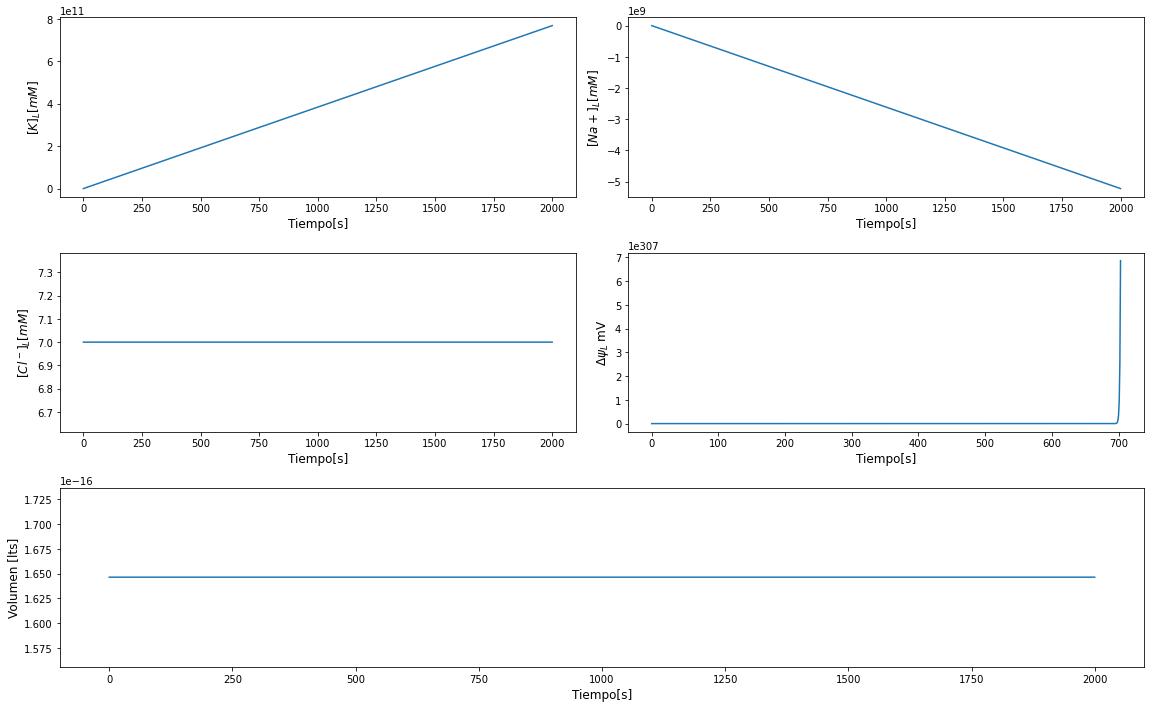

In [106]:
plot_result()